# Markov Chain Monte Carlo

In [9]:
using Plots
gr()
using LinearAlgebra
using Statistics

As before, we're going to use this funky function to read the data

In [10]:
function get_data()
    # \tablehead{ID &$x$ & $y$ & $\sigma_y$ & $\sigma_x$ &  \multicolumn{2}{c}{$\rho_{xy}$}}
    latex = """
1 & 201 & 592 & 61 & 9 & -0 & 84\\
2 & 244 & 401 & 25 & 4 & 0 & 31\\
3 & 47 & 583 & 38 & 11 & 0 & 64\\
4 & 287 & 402 & 15 & 7 & -0 & 27\\
5 & 203 & 495 & 21 & 5 & -0 & 33\\
6 & 58 & 173 & 15 & 9 & 0 & 67\\
8 & 202 & 504 & 14 & 4 & -0 & 05\\
9 & 198 & 510 & 30 & 11 & -0 & 84\\
10 & 158 & 416 & 16 & 7 & -0 & 69\\
11 & 165 & 393 & 14 & 5 & 0 & 30\\
12 & 201 & 442 & 25 & 5 & -0 & 46\\
13 & 157 & 317 & 52 & 5 & -0 & 03\\
14 & 131 & 311 & 16 & 6 & 0 & 50\\
15 & 166 & 400 & 34 & 6 & 0 & 73\\
16 & 160 & 337 & 31 & 5 & -0 & 52\\
17 & 186 & 423 & 42 & 9 & 0 & 90\\
18 & 125 & 334 & 26 & 8 & 0 & 40\\
19 & 218 & 533 & 16 & 6 & -0 & 78\\
20 & 146 & 344 & 22 & 5 & -0 & 56\\
"""
    lines = split(latex, '\n')
    lines = filter(x->(length(x)>0), lines)
    lines = filter(x->(length(x)>0), lines)

    x = zeros(length(lines))
    y = zeros(length(lines))
    yerr = zeros(length(lines))
    xerr = zeros(length(lines))
    for (i,line) in enumerate(lines)
        words = split(line, "&")
        x[i] = parse(Float64, words[2])
        y[i] = parse(Float64, words[3])
        yerr[i] = parse(Float64, words[4])
        xerr[i] = parse(Float64, words[5])
    end
    return x,y,xerr,yerr
end;

And call it to get our data set.

In [11]:
x,y,xerr,yerr = get_data();

We're going to start out using a subset of the data that does not have outliers.

In [12]:
xgood = x[5:end]
ygood = y[5:end]
yerrgood = yerr[5:end];

And, as before, we'll compute the best-fit parameters and covariances using linear algebra.  (We're doing this so we have something to compare against later!):

In [13]:
function weighted_least_squares_and_covariances(x, y, yerr)
    n = length(x)
    A = zeros(eltype(x), n, 2)
    A[:,1] .= 1.
    A[:,2] = x
    Wh = Diagonal(1. ./ yerr)
    B = (Wh*A) \ (Wh*y)
    (b,m) = B
    C = inv(A' * Wh' * Wh * A)
    return (b,m,C)
end;

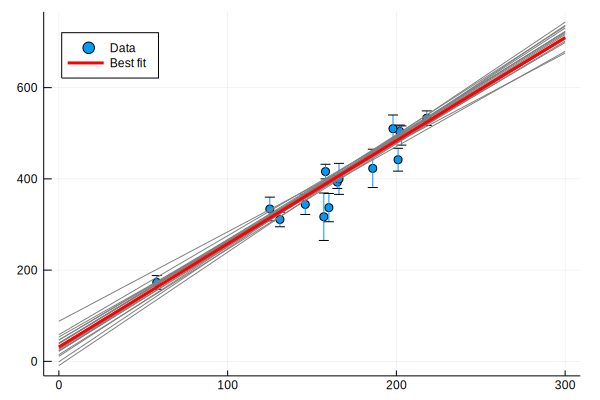

In [14]:
b_ls,m_ls,C_ls = weighted_least_squares_and_covariances(xgood, ygood, yerrgood)
xx=0:300
plot(xgood, ygood, yerr=yerrgood, seriestype=:scatter, legend=:topleft, label="Data")
for i in 1:20
    db,dm = real(sqrt(C_ls)) * randn(2)
    plot!(xx, x->(b_ls+db)+(m_ls+dm)*x, color=:grey, label="")
end
plot!(xx, x->b_ls+m_ls*x, linewidth=3, color=:red, label="Best fit")

We can also show this in the $b,m$ plane:

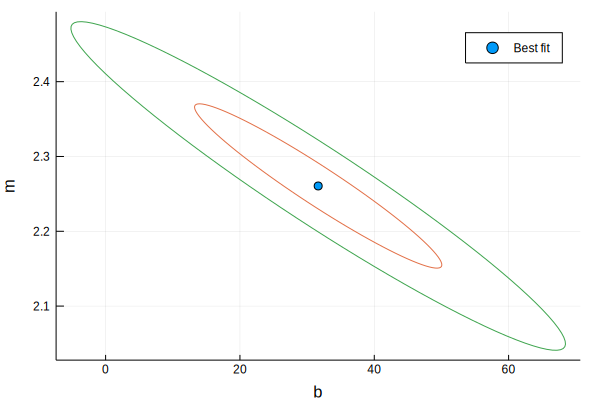

In [16]:
# Here I'm drawing an ellipse by computing values on a circle and pushing them through the sqrt(covariance) matrix.
angle = collect(range(0, stop=2*pi, length=100))
xx = [sin.(angle) cos.(angle)]
cMB = xx * real(sqrt(C_ls))
plot([b_ls], [m_ls], seriestype=:scatter, label="Best fit", xlabel="b", ylabel="m")
plot!(b_ls .+ cMB[:,1], m_ls .+ cMB[:,2], label="")
plot!(b_ls.+2 .* cMB[:,1], m_ls .+ 2 .*cMB[:,2], label="")

Since the best-fit solution is a Gaussian distribution, we can also easily draw samples:

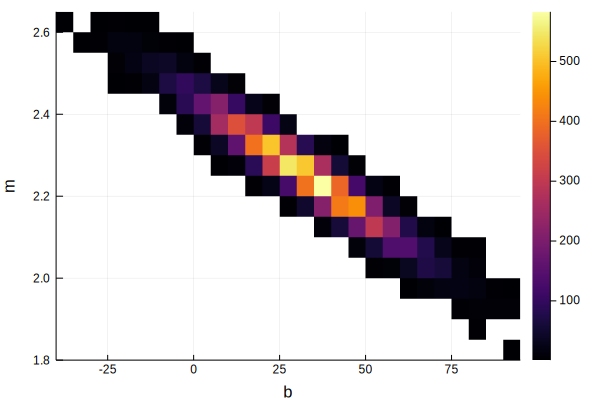

In [18]:
sMB = randn((10000,2)) * real(sqrt(C_ls))
histogram2d(b_ls.+sMB[:,1], m_ls.+sMB[:,2], xlabel="b", ylabel="m")

As before, we can write down the likelihood function for $b$ and $m$:

In [21]:
function line_log_likelihood(x, y, sigma, b, m)
    return -0.5 * sum(@. (y - (m*x + b))^2 / sigma^2)
end;

And define a shortcut version with the "good" data:

In [22]:
function good_line_lnl(bm)
    b,m = bm
    line_log_likelihood(xgood, ygood, yerrgood, b, m)
end;

Now, getting fussy for a second, we need to use the log-$posterior$, not the log-$likelihood$, which requires specifying a prior over our parameters $b$ and $m$.  Being un-fussy, we're going to set them to (improper) flat priors, so the posterior is just proportional to the likelihood.

In [23]:
function good_line_logprob(bm)
    logposterior = 0.
    return logposterior + good_line_lnl(bm)
end;

Let's start writing the Metropolis-Hastings MCMC algorithm from the notes:

## NOTE -- you have to add some code in here!!

In [24]:
chain = []
# initial guess -- in this case, doesn't have to be very good!
params = [200., 1.]
jumpsizes = [10., 0.1]
logprob = good_line_logprob(params)
for i in 1:1_000
    # Jump to new parameter values.  Use Gaussian random numbers ("randn") scaled by "jumpsizes"
    params_new = params .+ #  ADD CODE HERE!!
    logprob_new = good_line_logprob(params_new)
    # Note that since we're working in log-probs, you need to take the exp() of their difference
    # to get p(params_new) / p(params) --
    # For the Metropolis-Hasting acceptance step, you need to draw a uniform random number from [0 to 1].
    # In Julia you can do this with rand(Float64).
    if (exp(logprob_new - logprob) >= ##### ADD CODE HERE!! )
        logprob = logprob_new
        params = params_new
    end
    # Add the new (or old!) parameter values to our chain.
    append!(chain, params)
end
# append! makes "chain" a 1-d vector; reshape to a matrix
chain = reshape(chain, (2,Int64(length(chain)/2)))';

Notice that we're taking 1,000 steps here, so the chain will have shape (1000 x 2).

The values in your chain should look something like the plots below:

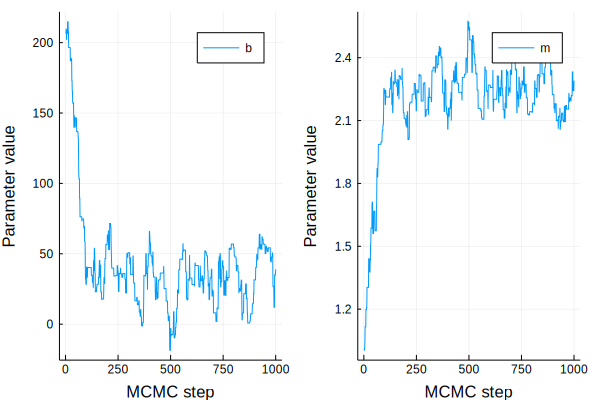

In [25]:
p1 = plot(chain[:,1], xlabel="MCMC step", ylabel="Parameter value", label="b")
p2 = plot(chain[:,2], xlabel="MCMC step", ylabel="Parameter value", label="m")
plot(p1, p2)

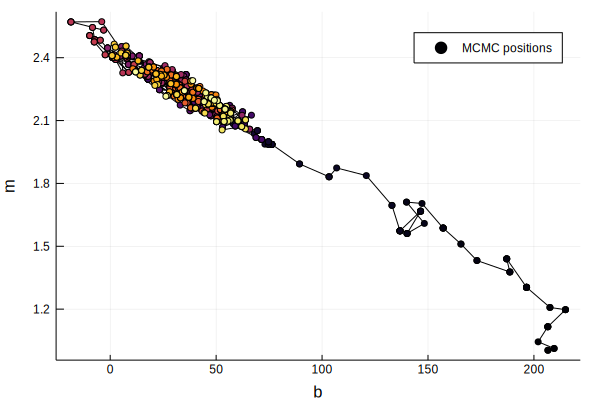

In [26]:
plot(chain[:,1], chain[:,2], color=:black, label="", xlabel="b", ylabel="m")
scatter!(chain[:,1], chain[:,2], zcolor=1:size(chain)[1], ms=3, label="MCMC positions", colorbar=false)

Observe how our "particle" started out down at $(200, 1)$ where we initialized it, but it quickly began "walking" toward the region of higher probability, and then it spent the rest of its time wandering around near the peak.

In MCMC, this initial phase of finding the high-probability region is called "burn-in", and it is common practice to discard some number of initial samples -- often hundreds or thousands of samples, depending on the complexity of the problem.

One super-powerful property of an MCMC sampling is that if you only care about one of the parameters -- say, $m$ in this example -- then you can just look at the values of the $m$ parameter of the samples and they *correctly marginalize over uncertainties in the other parameters*.  That's **awesome**.


To check that we get the right answer, let's compare our $m$ samples to the linear-algebra answer from above.

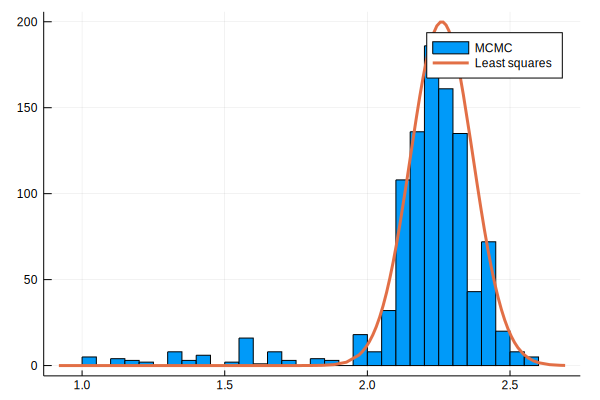

In [27]:
# We still have the "C_ls" (covariance of the least-squares solution) and "m_ls" variables kicking around.
histogram(chain[:,2], label="MCMC")
v = C_ls[2,2]
plot!(x->200 * exp(-0.5 * (x - m_ls)^2 / v), label="Least squares", linewidth=3)

Before we experiment more, let's do some "software engineering" to make our MCMC algorithm into a nice function.  Let's also collect some metrics on what it is doing.

In [28]:
function run_mcmc(logprob_function, initial, jumpsizes, nsteps)
    nparams = length(initial)
    # We're going to pre-allocate the matrix to hold the chain
    chain = zeros((nsteps, nparams))
    # Also remember the log-probabilities at the parameter values
    logprobs = zeros(nsteps)
    # Count how often we accept a move.
    accepts = 0
    # Start up!
    params = initial
    logprob = logprob_function(params)
    for i in 1:nsteps
        params_new = params .+ ##### ADD CODE HERE!
        logprob_new = #### ADD CODE HERE!
        if (### ADD CODE HERE!!)
            logprob = logprob_new
            params = params_new
            accepts += 1
        end
        chain[i,:] .= params
        logprobs[i] = logprob
    end
    return chain, logprobs, accepts / nsteps
end;

In [29]:
initial = [200., 1.]
jumps = [10., 0.1]
chain,logprobs,acceptance = run_mcmc(good_line_logprob, initial, jumps, 10_000);
acceptance

0.2979

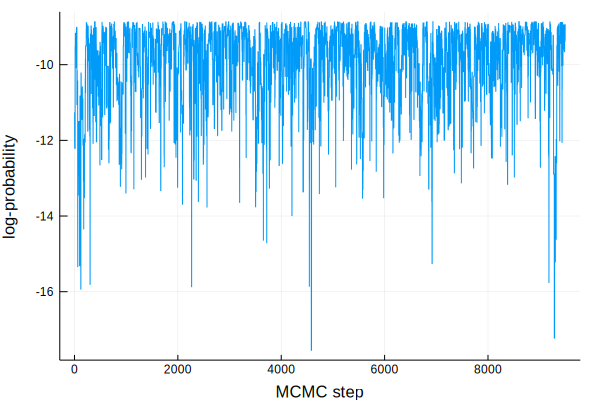

In [30]:
burnin = 500
plot(logprobs[burnin:end], ylabel="log-probability", xlabel="MCMC step", label="")

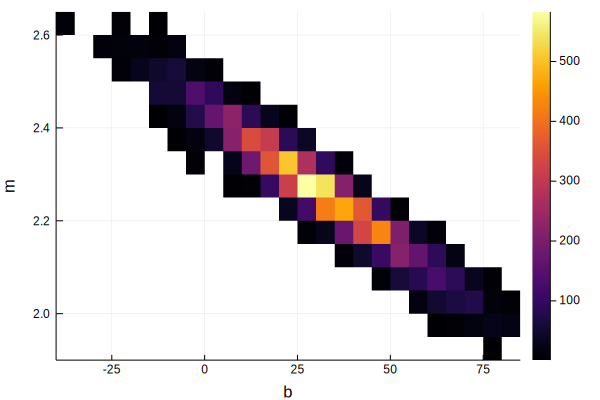

In [31]:
histogram2d(chain[burnin:end, 1], chain[burnin:end, 2], xlabel="b", ylabel="m")

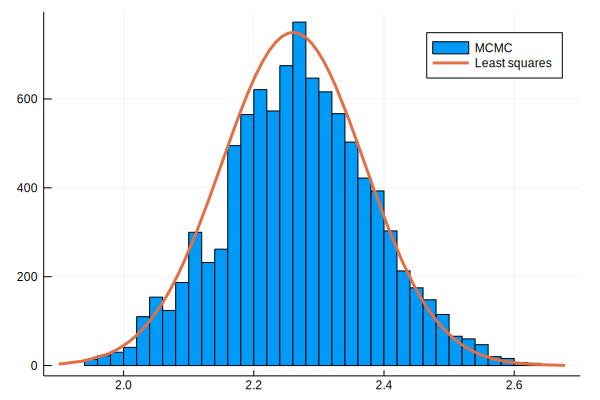

In [32]:
histogram(chain[burnin:end,2], label="MCMC")
v = C_ls[2,2]
plot!(x->750 * exp(-0.5 * (x - m_ls)^2 / v), label="Least squares", linewidth=3)

Now, time to play with this algorithm!

1. Notice how we had to set the "jump sizes".  Try changing the jump sizes, run MCMC for 1,000 steps, and observe what happens with the traces.  Also observe what happens to the "acceptance" fraction.  Can you explain what is happening?
2. Think about the acceptance fraction.  When the algorithm is working well, what do you think the acceptance fraction should be?  What would you change if the acceptance fraction was too small?

In [33]:
initial = [200., 1.]
jumps1 = [10., 0.1]
chain1,logprobs1,acceptance1 = run_mcmc(good_line_logprob, initial, jumps1, 1_000);
jumps2 = ### TRY SOME DIFFERENT JUMP SIZES -- eg, 10x bigger or smaller; change just one of the jump sizes; play around
chain2,logprobs2,acceptance2 = run_mcmc(good_line_logprob, initial, jumps2, 1_000);
acceptance1, acceptance2

(0.268, 0.064)

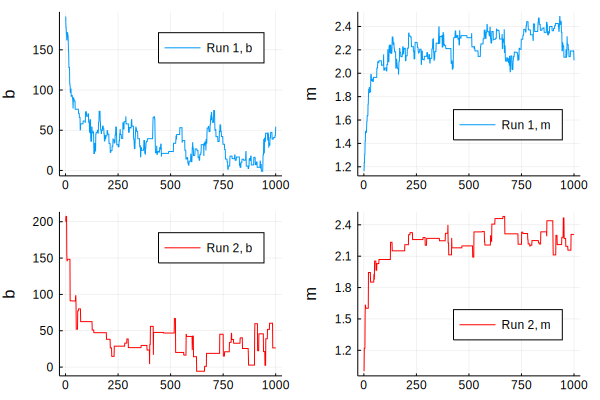

In [37]:
# Plot the *b* and *m* chains for the two jump sizes.
p1b = plot(chain1[:,1], ylabel="b", label="Run 1, b")
p1m = plot(chain1[:,2], ylabel="m", label="Run 1, m", legend=:bottomright)
p2b = plot(chain2[:,1], ylabel="b", label="Run 2, b", color=:red)
p2m = plot(chain2[:,2], ylabel="m", label="Run 2, m", color=:red, legend=:bottomright)
plot(p1b, p1m, p2b, p2m)

3. More about the jump sizes and acceptance fraction: here, we have two parameters and we have to set two jump sizes, and we're adjusting them until the acceptance fractions look right.  How can we tell which of the two jump sizes we should change?  Can you think of a variation on our MCMC algorithm that would allow us to tune the two jump sizes independently?  Try coding it up!

4. The MCMC algorithm has the slightly surprising step of saving a copy of the parameters even when we don't accept the jump.  This is *essential* for maintaining *detailed balance*, which is the basis for MCMC's theoretical guarantees.  HOWEVER, let's play with it.  Try different variants: save the $params\_new$ regardless of whether the jump is accepted or not.  Only save params when a jump is accepted.  Observe the results -- can you determine for yourself that the distributions you get out are correct or not?

5. We are "jumping" to $params\_new$ by moving the two parameters independently.  Yet, we know that these parameters are covariant.  What would be a better *proposal distribution*?  Try coding it up!

Next time, we'll switch to our 5-parameter foreground-background model and see how MCMC makes it easier/harder to use.